In [11]:
import pandas as pd

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

import tensorflow as tf
from tensorflow import keras


path = os.path.abspath("..")
filepath = "/data/AAPL.csv"

data = pd.read_csv(path + filepath, parse_dates=["Date"], index_col=0)

target = "Close" #close price

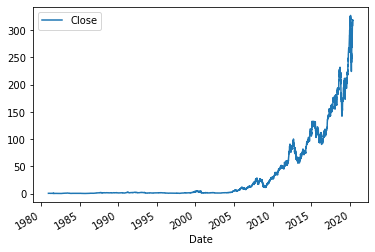

In [12]:
data.plot(y="Close")

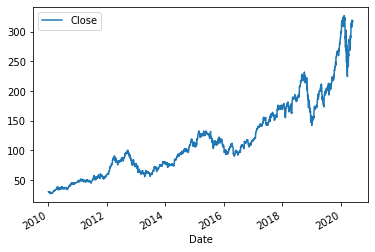

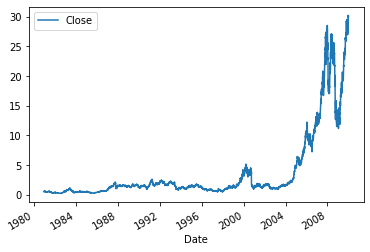

In [16]:
data[data.index > "2010"].plot(y="Close")
data[data.index <= "2010"].plot(y="Close")

## data prep

### cut time series and target col (Close Value)

In [23]:
data_past_2010 = data[data.index > "2010"][target].copy()

### change data types (not necessary)

In [27]:
data_past_2010

Date
2010-01-04     30.572857
2010-01-05     30.625713
2010-01-06     30.138571
2010-01-07     30.082857
2010-01-08     30.282858
                 ...    
2020-05-22    318.890015
2020-05-26    316.730011
2020-05-27    318.109985
2020-05-28    318.250000
2020-05-29    317.940002
Name: Close, Length: 2619, dtype: float64

### train test split (keep sequence!)

In [25]:

train_size = int(len(data_past_2010) * 0.9)

train = data_past_2010.iloc[:train_size]
test = data_past_2010.iloc[train_size:]

display("train shape: ", train.shape, "test shape: ", test.shape)

'train shape: '

(2357,)

'test shape: '

(262,)

### scale data

In [39]:
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
#scaler = MinMaxScaler()

## reshape test/train from flat array [1,2,3,...] to [[1],[2],[3],...]
train = np.array(train).reshape(-1,1)
test = np.array(test).reshape(-1,1)


scaler = scaler.fit(train)

train = scaler.transform(train)
test = scaler.transform(test)


In [44]:
print("train min", train.min())
print("train max ", train.max())
print("train std ", train.std())

print("test min  ", test.min())
print("test max  ", test.max())
print("test std  ", test.std())

train min -1.5472765755278575
train max  2.663053153684454
train std  0.9999999999999999
test min   1.4538663032853703
test max   4.620343323758275
test std   0.9132745349463925


### create sequences (30 days)

In [48]:

def create_sequences(data, TIME_STEPS):
    X_sequences, Y_sequences = [], []

    for i in range(len(data) - TIME_STEPS):
        seq_x = data[i: (i + TIME_STEPS)]
        seq_y = data[i + TIME_STEPS]

        X_sequences.append(seq_x)
        Y_sequences.append(seq_y)

    return np.array(X_sequences), np.array(Y_sequences)



In [51]:

TIME_STEPS = 30

x_train, y_train = create_sequences(train, TIME_STEPS)
x_test, y_test = create_sequences(test, TIME_STEPS)




In [57]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(2327, 30, 1) (2327, 1)
(232, 30, 1) (232, 1)


In [64]:
x_train[:2]

array([[[-1.4827302 ],
        [-1.48164269],
        [-1.49166559],
        [-1.4928119 ],
        [-1.4886969 ],
        [-1.49419334],
        [-1.50121821],
        [-1.49260615],
        [-1.49619207],
        [-1.50647952],
        [-1.47970277],
        [-1.48943173],
        [-1.50018948],
        [-1.53052274],
        [-1.51488582],
        [-1.50645011],
        [-1.5007479 ],
        [-1.52599629],
        [-1.54724719],
        [-1.53939935],
        [-1.53607797],
        [-1.52617263],
        [-1.54727658],
        [-1.53725368],
        [-1.54119231],
        [-1.535108  ],
        [-1.538253  ],
        [-1.52781863],
        [-1.52279249],
        [-1.51391588]],

       [[-1.48164269],
        [-1.49166559],
        [-1.4928119 ],
        [-1.4886969 ],
        [-1.49419334],
        [-1.50121821],
        [-1.49260615],
        [-1.49619207],
        [-1.50647952],
        [-1.47970277],
        [-1.48943173],
        [-1.50018948],
        [-1.53052274],
        [

In [65]:
y_train[:2]

array([[-1.51641423],
       [-1.51529732]])

In [66]:
x_train.shape

(2327, 30, 1)

## create LSTM model

In [89]:
model = keras.Sequential()

model.add(keras.layers.LSTM(
    units=64,
    input_shape=(x_train.shape[1], x_train.shape[2])
))

#model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1))


model.compile(loss="mse", optimizer="adam")


## train model

In [90]:
epochs = 10
batch_size = 32
validation_split = 0.1

train_loss = []
test_loss = []



for i in range(epochs):
    print("Epoch: ", i)
    history = model.fit(x_train, y_train, epochs=1, batch_size=batch_size, validation_split=validation_split, shuffle=False)
    train_loss.append(history.history["loss"])
    test_loss.append(history.history["val_loss"])
    model.reset_states()
    



Epoch:  0
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 9s 4ms/sample - loss: 0.1767 - val_loss: 0.0749
Epoch:  1
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 4s 2ms/sample - loss: 0.1178 - val_loss: 0.5472
Epoch:  2
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0373 - val_loss: 0.0272
Epoch:  3
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 4s 2ms/sample - loss: 0.0103 - val_loss: 0.0256
Epoch:  4
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0054 - val_loss: 0.0229
Epoch:  5
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] - 5s 2ms/sample - loss: 0.0047 - val_loss: 0.0204
Epoch:  6
Train on 2094 samples, validate on 233 samples
2094/2094 [==============================] 

In [96]:
test_loss

[[0.0748845967164367],
 [0.5472058639761715],
 [0.027222815709180587],
 [0.02562588016010917],
 [0.022869361740389095],
 [0.020374690682143613],
 [0.01885367920342433],
 [0.017864096166302208],
 [0.017208840721986324],
 [0.016720824615126514]]

## validate model

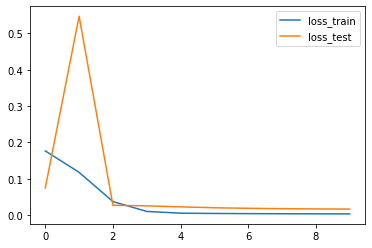

In [95]:

pd_losses = pd.DataFrame({"loss_train": np.array(train_loss).flatten(), "loss_test": np.array(test_loss).flatten()})

pd_losses.plot(legend=True)

## make prediction

In [97]:
x_test_pred = model.predict(x_test)

In [102]:
test

array([[1.79911307],
       [1.77689214],
       [1.65529441],
       [1.72751251],
       [1.64891626],
       [1.58472268],
       [1.57052594],
       [1.55530041],
       [1.53781193],
       [1.55674079],
       [1.49028396],
       [1.4538663 ],
       [1.58431108],
       [1.64397816],
       [1.69911905],
       [1.80055315],
       [1.85055032],
       [1.89643226],
       [1.88367591],
       [1.88285275],
       [1.85384237],
       [1.87750338],
       [1.97132487],
       [1.95939139],
       [1.99210572],
       [1.97811463],
       [1.97399971],
       [1.91206937],
       [1.99910111],
       [1.99786665],
       [1.96042019],
       [2.03510718],
       [2.05938541],
       [2.09395141],
       [2.09024776],
       [2.0036276 ],
       [2.028729  ],
       [2.06967286],
       [2.0392221 ],
       [2.07111325],
       [2.11041139],
       [2.09580307],
       [2.07214206],
       [2.11967003],
       [2.05650493],
       [2.15176681],
       [2.18509804],
       [2.181

In [99]:
x_test_pred

array([[1.9539024],
       [1.9550755],
       [1.9630877],
       [1.9731574],
       [1.9871045],
       [2.000833 ],
       [2.0051856],
       [2.0100985],
       [2.0166612],
       [2.0188303],
       [2.023485 ],
       [2.0314066],
       [2.0377593],
       [2.0414927],
       [2.0491834],
       [2.0495594],
       [2.0588574],
       [2.0706627],
       [2.0824647],
       [2.090741 ],
       [2.099298 ],
       [2.1100588],
       [2.1176748],
       [2.1327882],
       [2.137564 ],
       [2.1324568],
       [2.1019163],
       [2.0755167],
       [2.0505733],
       [2.0367508],
       [2.0216846],
       [2.0102196],
       [2.0201287],
       [2.0203695],
       [2.0215623],
       [2.032651 ],
       [2.0516376],
       [2.0714388],
       [2.095901 ],
       [2.1187143],
       [2.1197078],
       [2.124607 ],
       [2.1196628],
       [2.115152 ],
       [2.1163068],
       [2.117144 ],
       [2.1128345],
       [2.1161237],
       [2.127632 ],
       [2.1401267],


In [72]:
x_pred = []
x_true = []

for i in range(30):
    
    x_pred_value = x_test_pred[len(x_test_pred)-1][i][0]
    x_pred.append(x_pred_value)
    
    x_true_value = x_test[len(x_test)-1][i][0]
    x_true.append(x_true_value)

    
    

In [117]:
x_pred_inverse_scaled = scaler.inverse_transform(x_test_pred)
x_true_inverse_scaled = scaler.inverse_transform(test[TIME_STEPS:])

In [123]:
a = pd.DataFrame({"true": np.array(x_true_inverse_scaled).flatten(), "pred": np.array(x_pred_inverse_scaled).flatten()})

In [124]:
a["diff"] = a["true"] - a["pred"]

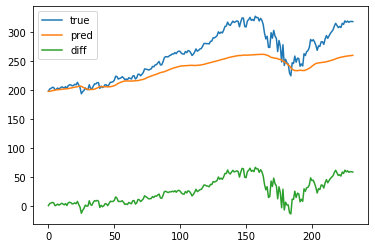

In [125]:
ax1 = a["true"].plot(legend=True)
ax2 = a["pred"].plot(legend=True,ax=ax1)
a["diff"].plot(legend=True, ax=ax2)